# Portfolio's Building #

### Rebalancing Weights ###

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from config import get_tickers
from data_downloader import get_market_data
from portfolios_toolkit import calculate_analytics
from portfolios_toolkit import markowitz_weights

In [2]:
tickers = get_tickers(mod="2.4")

tickers

['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA']

In [3]:
# Import data
df_returns = pd.DataFrame()

for ticker in tickers:
    df = get_market_data(
        ticker=ticker, 
        start_date='2015-01-01', 
        end_date='2025-01-01', 
        returns=True
    )
    
    returns = df['returns'].rename(ticker)
    
    df_returns = pd.concat([df_returns, returns], axis=1)
    
    print(f'Data Ready for {ticker}')

Data Ready for AAPL
Data Ready for AMZN
Data Ready for META
Data Ready for MSFT
Data Ready for NVDA


In [4]:
df_returns

,AAPL,AMZN,META,MSFT,NVDA
2015-01-05 00:00:00,-0.028576,-0.020731,-0.016191,-0.009238,-0.017035
2015-01-06 00:00:00,0.000094,-0.023098,-0.013565,-0.014786,-0.030787
2015-01-07 00:00:00,0.013925,0.010544,0.000000,0.012625,-0.002609
2015-01-08 00:00:00,0.037703,0.006813,0.026309,0.028994,0.036927
2015-01-09 00:00:00,0.001072,-0.011818,-0.005644,-0.008441,0.004020
...,...,...,...,...,...
2024-12-24 00:00:00,0.011413,0.017573,0.013084,0.009330,0.003930
2024-12-26 00:00:00,0.003171,-0.008770,-0.007266,-0.002781,-0.002070
2024-12-27 00:00:00,-0.013331,-0.014641,-0.005885,-0.017453,-0.021088
2024-12-30 00:00:00,-0.013352,-0.011010,-0.014391,-0.013328,0.003497


In [5]:
df_returns.mean()

AAPL    0.000927
AMZN    0.001056
META    0.000801
MSFT    0.000935
NVDA    0.002238
dtype: float64

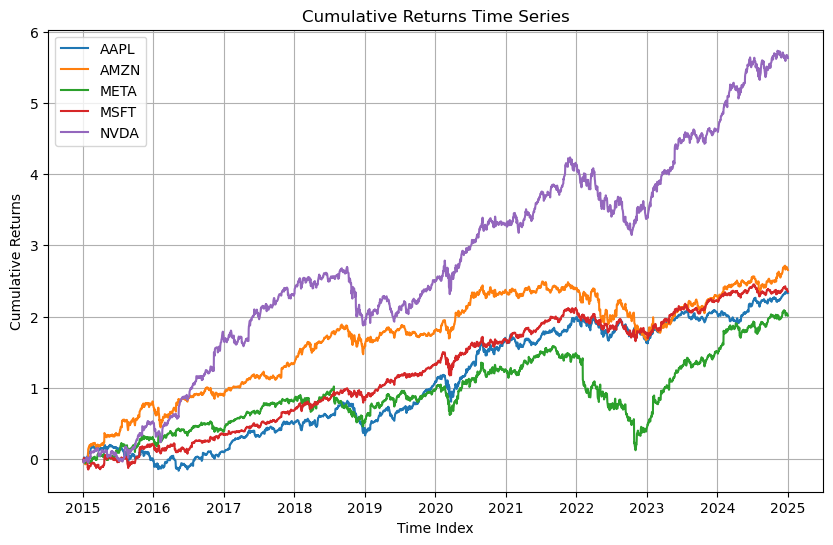

In [6]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns.cumsum(), label=df_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [7]:
# Let us Calculate the Weights
def rolling_weights(
    returns, 
    desired_returns, 
    window=252, 
    rebalance_freq=126
):

    # Lists to Store Things
    weights_list = []
    dates = []

    for i in range(window, len(returns), rebalance_freq):
        past_returns = returns.iloc[i - window:i]  # Rolling Window
        past_excepted_returns = past_returns.mean()
        past_cov_matrix = past_returns.cov()

        # Calculate Weights
        w = markowitz_weights(past_excepted_returns, past_cov_matrix, desired_returns)

        # Save weights and dates
        weights_list.append(w)
        dates.append(returns.index[i])

    # Create the DataFrame
    weights_df = pd.DataFrame(weights_list, index=dates, columns=returns.columns)

    # Expand the DataFrame
    weights_df = weights_df.reindex(returns.index, method='ffill')

    return weights_df.dropna()

In [8]:
# Create the DataFrames of Returns
df_weights = rolling_weights(df_returns, 0.002)

df_weights

,AAPL,AMZN,META,MSFT,NVDA
2016-01-05 00:00:00,0.007732,0.370243,0.305343,0.002325,0.314356
2016-01-06 00:00:00,0.007732,0.370243,0.305343,0.002325,0.314356
2016-01-07 00:00:00,0.007732,0.370243,0.305343,0.002325,0.314356
2016-01-08 00:00:00,0.007732,0.370243,0.305343,0.002325,0.314356
2016-01-11 00:00:00,0.007732,0.370243,0.305343,0.002325,0.314356
...,...,...,...,...,...
2024-12-24 00:00:00,0.255702,0.120632,0.042714,0.376846,0.204107
2024-12-26 00:00:00,0.255702,0.120632,0.042714,0.376846,0.204107
2024-12-27 00:00:00,0.255702,0.120632,0.042714,0.376846,0.204107
2024-12-30 00:00:00,0.255702,0.120632,0.042714,0.376846,0.204107


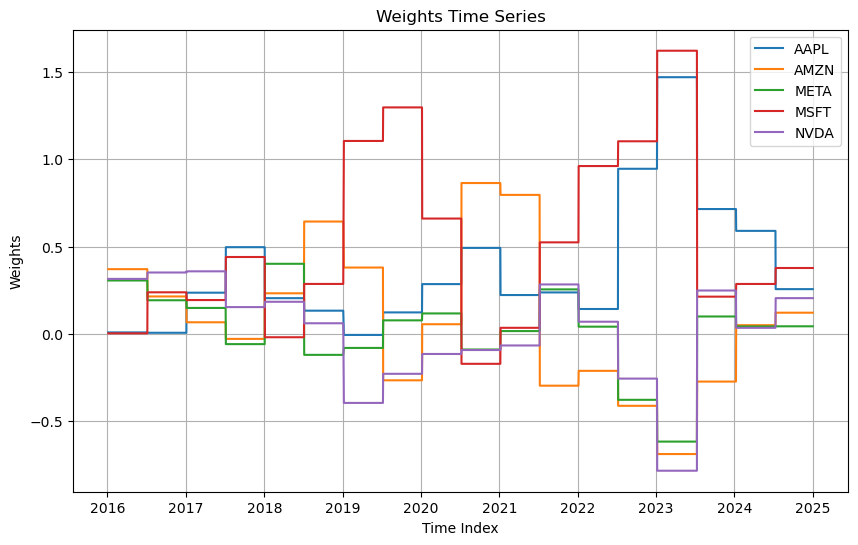

In [9]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_weights, label=df_weights.columns, alpha=1)
# Config
plt.title('Weights Time Series')
plt.xlabel('Time Index')
plt.ylabel('Weights')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [10]:
# Common Index

common_index = df_returns.index.intersection(df_weights.index)  # Fechas en común
df_returns_reindex = df_returns.reindex(common_index)
df_weights = df_weights.reindex(common_index)

df_returns_reindex

,AAPL,AMZN,META,MSFT,NVDA
2016-01-05 00:00:00,-0.025378,-0.005036,0.004977,0.004551,0.015937
2016-01-06 00:00:00,-0.019764,-0.001800,0.002334,-0.018332,-0.042229
2016-01-07 00:00:00,-0.043121,-0.039841,-0.050287,-0.035402,-0.040452
2016-01-08 00:00:00,0.005274,-0.001465,-0.006044,0.003062,-0.021700
2016-01-11 00:00:00,0.016062,0.017456,0.001848,-0.000573,0.001686
...,...,...,...,...,...
2024-12-24 00:00:00,0.011413,0.017573,0.013084,0.009330,0.003930
2024-12-26 00:00:00,0.003171,-0.008770,-0.007266,-0.002781,-0.002070
2024-12-27 00:00:00,-0.013331,-0.014641,-0.005885,-0.017453,-0.021088
2024-12-30 00:00:00,-0.013352,-0.011010,-0.014391,-0.013328,0.003497


In [11]:
# Create the Portfolio Returns

df_weighted_returns = df_returns_reindex * df_weights

df_weighted_returns

,AAPL,AMZN,META,MSFT,NVDA
2016-01-05 00:00:00,-0.000196,-0.001865,0.001520,0.000011,0.005010
2016-01-06 00:00:00,-0.000153,-0.000667,0.000713,-0.000043,-0.013275
2016-01-07 00:00:00,-0.000333,-0.014751,-0.015355,-0.000082,-0.012716
2016-01-08 00:00:00,0.000041,-0.000542,-0.001845,0.000007,-0.006822
2016-01-11 00:00:00,0.000124,0.006463,0.000564,-0.000001,0.000530
...,...,...,...,...,...
2024-12-24 00:00:00,0.002918,0.002120,0.000559,0.003516,0.000802
2024-12-26 00:00:00,0.000811,-0.001058,-0.000310,-0.001048,-0.000423
2024-12-27 00:00:00,-0.003409,-0.001766,-0.000251,-0.006577,-0.004304
2024-12-30 00:00:00,-0.003414,-0.001328,-0.000615,-0.005023,0.000714


In [12]:
# Create the Portfolio Returns
df_returns_portfolio = df_returns.copy()

# Add the columns
df_returns_portfolio['Portfolio'] =  df_weighted_returns.sum(axis = 1)

df_returns_portfolio['Portfolio'].dropna()

2016-01-05    0.004479
2016-01-06   -0.013425
2016-01-07   -0.043238
2016-01-08   -0.009161
2016-01-11    0.007680
                ...   
2024-12-24    0.009915
2024-12-26   -0.002028
2024-12-27   -0.016308
2024-12-30   -0.009666
2024-12-31   -0.011045
Name: Portfolio, Length: 2263, dtype: float64

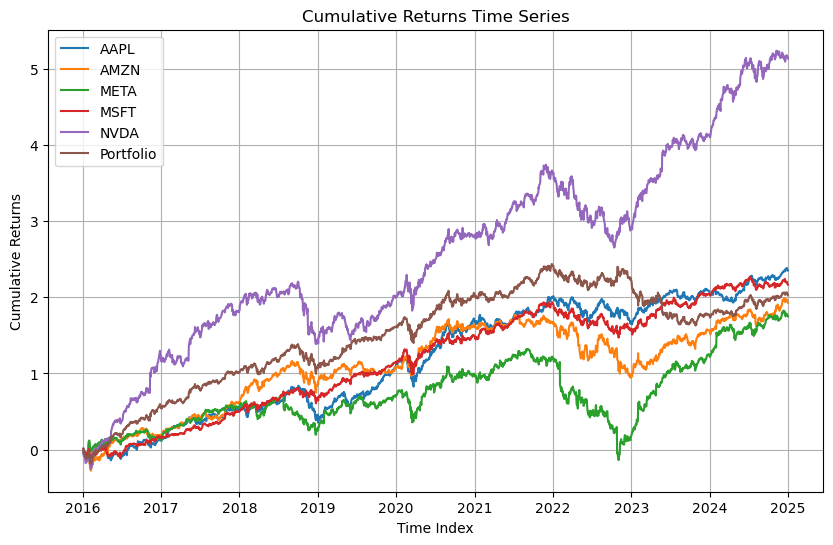

In [13]:
# Time Series Graphs

df_plot = df_returns_portfolio.dropna()

plt.figure(figsize=(10, 6))
plt.plot(df_plot.cumsum(), label=df_plot.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

### Define different rebalancing frequencies ###

In [14]:
# Create weights for different rebalancing frequencies

df_weights_5d = rolling_weights(df_returns, 0.0025, rebalance_freq=5)
df_weights_21d = rolling_weights(df_returns, 0.0025, rebalance_freq=21)
df_weights_63d = rolling_weights(df_returns, 0.0025, rebalance_freq=63)
df_weights_126d = rolling_weights(df_returns, 0.0025, rebalance_freq=126)
df_weights_252d = rolling_weights(df_returns, 0.0025, rebalance_freq=252)

In [15]:
# Create the Returns

df_weighted_returns_5d = df_returns_reindex * df_weights_5d
df_weighted_returns_21d = df_returns_reindex * df_weights_21d
df_weighted_returns_63d = df_returns_reindex * df_weights_63d
df_weighted_returns_126d = df_returns_reindex * df_weights_126d
df_weighted_returns_252d = df_returns_reindex * df_weights_252d

In [16]:
# Add the columns

df_returns_reindex['5d_port'] = df_weighted_returns_5d.sum(axis = 1)
df_returns_reindex['21d_port'] = df_weighted_returns_21d.sum(axis = 1)
df_returns_reindex['63d_port'] = df_weighted_returns_63d.sum(axis = 1)
df_returns_reindex['126d_port'] = df_weighted_returns_126d.sum(axis = 1)
df_returns_reindex['252d_port'] = df_weighted_returns_252d.sum(axis = 1)

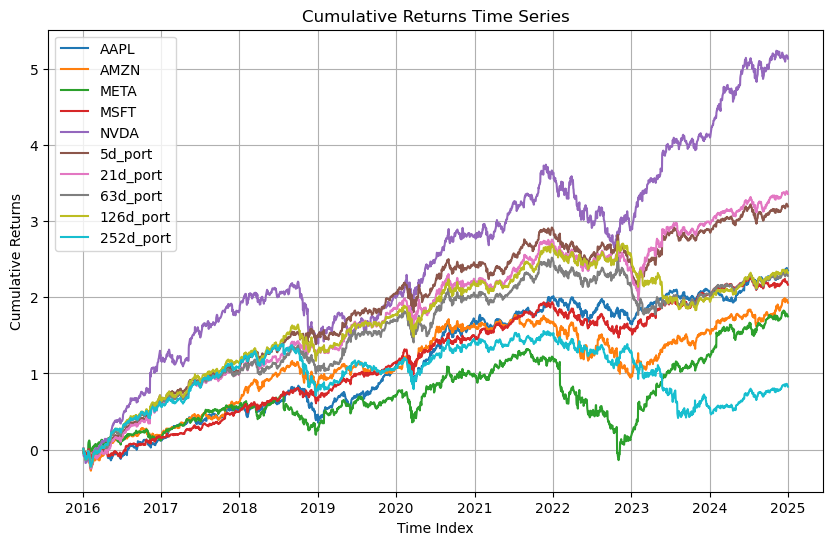

In [17]:
# Time Series Graphs

plt.figure(figsize=(10, 6))
plt.plot(df_returns_reindex.cumsum(), label=df_returns_reindex.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

### Comparing Portfolios ###

In [18]:
# Now the table
analytics_table = calculate_analytics(df_returns_reindex)

analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
AAPL,0.261790,0.286519,0.913690,-0.004855,-0.027281
AMZN,0.214899,0.325844,0.659515,-0.008223,-0.031989
META,0.194781,0.389727,0.499790,-0.014499,-0.035804
MSFT,0.241155,0.270320,0.892109,-0.004639,-0.026980
NVDA,0.571924,0.495619,1.153960,-0.010846,-0.046721
5d_port,0.355653,0.360099,0.987656,-0.009284,-0.034760
21d_port,0.373930,0.361302,1.034952,-0.007914,-0.035009
63d_port,0.254164,0.341605,0.744029,-0.007525,-0.034590
126d_port,0.258512,0.344926,0.749470,-0.009001,-0.035209
252d_port,0.092036,0.350459,0.262614,-0.011379,-0.035797
